## Experiment 2: order sensitivity

In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm.auto import tqdm
from gp import *
import math


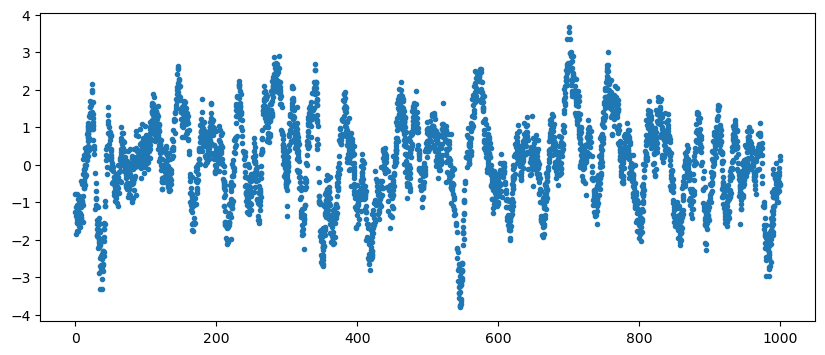

In [2]:
#data
N_total = 4000
X = 1000*torch.rand(N_total,1)
hypers = [1, 5, 0.1]
gp_true = GP(hypers = hypers)
y = gp_true.sample_from_prior(X)
X_data = X.detach().cpu()
y_data = y.detach().cpu()

plt.figure(figsize=(10,4))
plt.plot(X_data,y_data,'.')
    

In [39]:
#setting up
# variables to extract
list_nsamples = [500, 1000, 1500, 2000, 3000, 4000]
list_M = [50, 100, 150]


In [ ]:
out_nll = []
times_nll = []

out_elbo = []

times_elbo = []


In [40]:
out_proj = []
times_proj = []

#training setting
n_steps = 2001
lr = 0.01
tol = 1e-3
optimizer = 'Adam'

In [49]:
#training
print('starting training ....')
idx_total = torch.randperm(N_total)
for n_samples in list_nsamples:
    print(f'---observations = {n_samples}')
    # choose n unique indices at random
    idx = idx_total[:n_samples]
    # subset of the data
    X_train = X_data[idx]
    y_train = y_data[idx]
    
    
    ##### Vanilla GP (NLL) #####
    # Vanilla GP (NLL)
    #!gp_nll = GP(X_train, y_train, kernel = 'SE')
    #!out = gp_nll.train_step(obj = 'nll', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)

    #!times_nll.append(out["time"])     # save elapsed time
    #!out_nll.append(out["nll"])
    
    for M in list_M:
        Meq = M
        if M > 0.5*n_samples:
            times_elbo.append(0)
            out_elbo.append(0)
            times_proj.append(0)     # save elapsed time
            out_proj.append(0)
            break
        print(f'------M = {Meq}')
        
    
        ##### SparseGP (ELBO) ##### 
        # SparseGP (ELBO)
        #!gp_elbo = GP(X_train, y_train, kernel = 'SE', M=Meq, method = 'VFE')
        #!out = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)        

        #!times_elbo.append(out["time"])     # save elapsed time
        #!out_elbo.append(out["nll"])

        ##### ProjGP ##### 
        gp_proj = GP(X_train, y_train, kernel = 'SE', M=Meq, method = 'proj-repulsive')
        out = gp_proj.train_step(obj = 'proj', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)        

        times_proj.append(out["time"])     # save elapsed time
        out_proj.append(out["nll"])
        
print('Training complete')        
    

starting training ....
---observations = 500
------M = 50
Optimising proj using Adam
Epoch 0: loss = 68.9702
Epoch 200: loss = 43.6636
Early stop at iteration 305: loss did not improve for 5 steps.
Elapsed time: 2.7[s] with NLL = 358.74
------M = 100
Optimising proj using Adam
Epoch 0: loss = 133.3829
Epoch 200: loss = 78.0382
Early stop at iteration 322: loss did not improve for 5 steps.
Elapsed time: 3.5[s] with NLL = 362.20
------M = 150
Optimising proj using Adam
Epoch 0: loss = 204.3976
Epoch 200: loss = 118.2740
Early stop at iteration 336: loss did not improve for 5 steps.
Elapsed time: 4.7[s] with NLL = 357.09
---observations = 1000
------M = 50
Optimising proj using Adam
Epoch 0: loss = 70.4809
Epoch 200: loss = 36.2343
Early stop at iteration 343: loss did not improve for 5 steps.
Elapsed time: 8.4[s] with NLL = 588.36
------M = 100
Optimising proj using Adam
Epoch 0: loss = 127.3960
Epoch 200: loss = 61.4259
Early stop at iteration 342: loss did not improve for 5 steps.
Elap

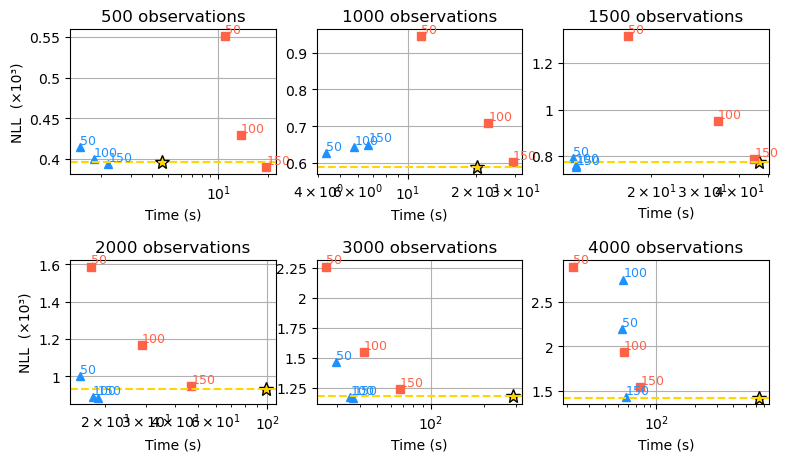

In [57]:
##### plot the results 
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, pos: f'{x/1000:.4g}')

#!out_elbo = out_proj
#!times_elbo = times_proj
N = len(list_nsamples)
M = len(list_M)

fig, axs = plt.subplots(2, math.ceil(N/2), figsize=(8, 5), sharey=False)  # 2 rows
axs = axs.flatten()

for i in range(N):
    ax = axs[i]
    
    # plot time vs output for each method
    ax.semilogx(times_nll[i], out_nll[i], '*-', c='gold', markersize=10, 
    markeredgecolor='k',   # black border
    markeredgewidth=1,   # thickness of the border
    label='NLL')
    for j in range(M):  
    
        ax.semilogx(times_elbo[M*i + j], out_elbo[M*i + j], 's-', c='tomato', label='ELBO')
        ax.text(times_elbo[M*i + j], out_elbo[M*i + j], list_M[j], c='tomato', fontsize=9, ha='left', va='bottom')
        ax.semilogx(times_proj[M*i + j], out_proj[M*i + j],'^-', c='dodgerblue' , label='Proj')
        ax.text(times_proj[M*i + j], out_proj[M*i + j], list_M[j], c='dodgerblue', fontsize=9, ha='left', va='bottom')
    
    ax.axhline(y=out_nll[i], color='gold', linestyle='--', label='grund truth')  # constant y
    ax.yaxis.set_major_formatter(formatter)


    
    
    ax.set_title(f'{list_nsamples[i]} observations')
    ax.set_xlabel('Time (s)')
    if i % math.ceil(N/2) == 0:   # only first col gets y-label
        ax.set_ylabel('NLL  (×10³)')
    #ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.6, bottom=0.18)  

plt.savefig("img/exp1.pdf", bbox_inches='tight', pad_inches=0)


In [6]:
list_M

[50, 100, 150]